In [1]:
# Run `jupyter notebook` in the braidpool/tests directory, or add the path to the tests/ directory here
#sys.path.append('../braidpool/tests/') 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [12,4]
from joblib import Parallel, delayed, cpu_count
from functools import reduce
import numpy as np
import scipy
from scipy.special import lambertw as W
import time
import braid
from simulator import *

Generated braid: 31 beads with 15 cohorts, 4 tips, and 16 beads in the highest work path.


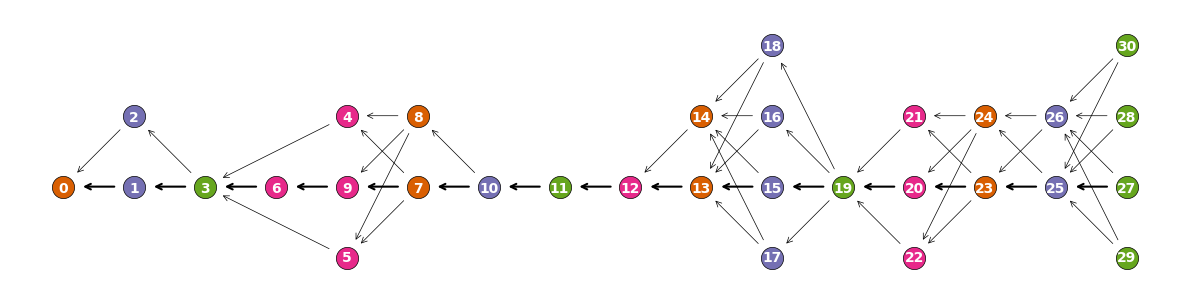

In [2]:
# Generate a random braid to demonstrate the code. Re-run this block to generate a different braid.
# The target and hashrate parameters are measured on my CPU (Intel 3.3 GHz) Run `simulator.py --mine` to benchmark your CPU
n = Network(nnodes=50, target=2**240-1, hashrate=800000)
# Use `mine=False` to use the geometric distribution to simulate mining. Use `mine=True` to actually compute sha256d hashes (slower)
n.simulate(nbeads=30, mine=False) 

# Each node has its own braid, look at node 0's braid here.
b = n.nodes[0].braid
# Extract the `parents` dict as integers (hashes) instead of instances of the <Bead> object
hashed_parents = {int(k): set(map(int, v)) for k,v in dict(b).items()}
# Remap integers (hashes) in the parents array to sequential integers for display purposes
parents  = braid.number_beads(hashed_parents)
children = braid.reverse(parents)
work     = braid.descendant_work(parents)
hwpath   = braid.highest_work_path(parents, children)
cohorts  = list(braid.cohorts(parents))
print(f"Generated braid: {len(b.beads)} beads with {len(cohorts)} cohorts, {len(b.tips)} tips, "
      f"and {len(hwpath)} beads in the highest work path.")
fig = b.plot()

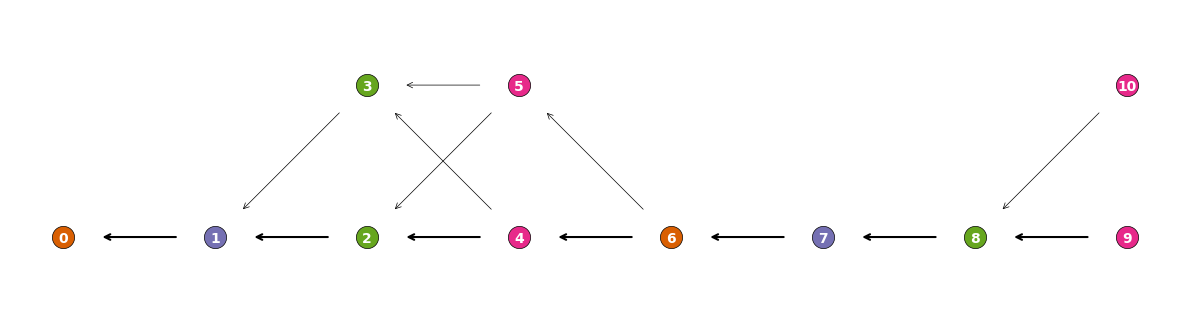

parents =  {0: set(), 1: {0}, 2: {1}, 3: {1}, 4: {2, 3}, 5: {2, 3}, 6: {4, 5}, 7: {6}, 8: {7}, 9: {8}, 10: {8}}


In [3]:
# Generate a random "thin braid".
n = Network(nnodes=50, target=2**238-1) # difficulty 2**238-1 is "high" for a global network with CPU mining
n.simulate(nbeads=10, mine=False)
fig = n.nodes[0].braid.plot()
# Create a sequentially-numbered parents dict which is nice for display instead of hashes from the simulator
hashed_parents = {int(k): set(map(int, v)) for k,v in dict(n.nodes[0].braid).items()}
parents = braid.number_beads(hashed_parents)
print("parents = ", parents)

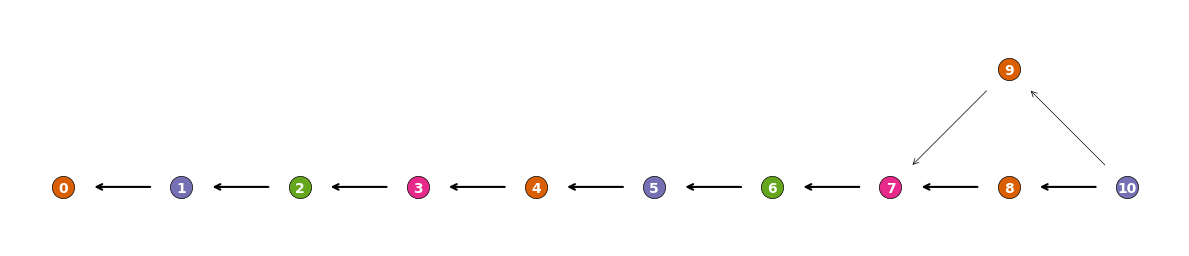

In [4]:
# Generate Fig 1 for braid_consensus.md. Your braid above is random and won't be the same.
parents = {0: set(), 1: {0}, 2: {1}, 3: {2}, 4: {3}, 5: {4}, 6: {5}, 7: {6}, 8: {7}, 9: {7}, 10: {9,8}}
b = Braid(parents=parents)
b.plot("/tmp/thin_braid.png")

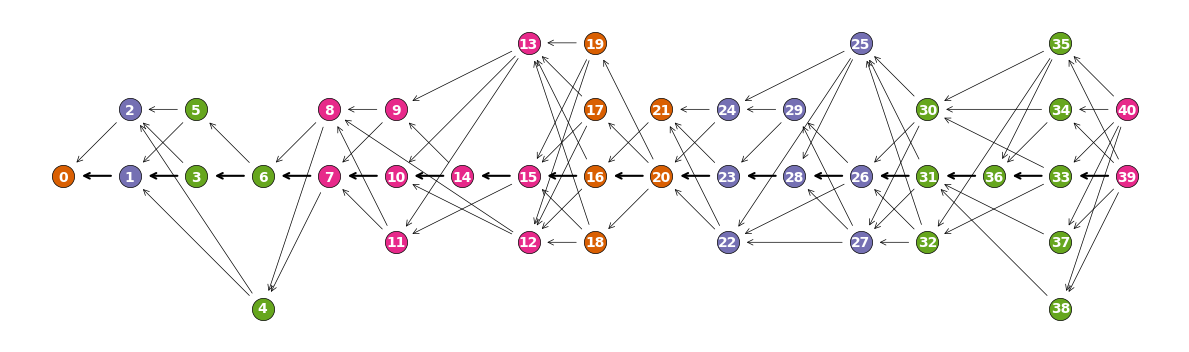

parents =  {0: set(), 1: {0}, 2: {0}, 3: {1, 2}, 4: {1, 2}, 5: {1, 2}, 6: {3, 5}, 7: {4, 6}, 8: {4, 6}, 9: {8, 7}, 10: {7}, 11: {8, 7}, 12: {8, 10}, 13: {9, 10, 11}, 14: {9, 10}, 15: {11, 14}, 16: {12, 13, 15}, 17: {12, 13, 15}, 18: {12, 13, 15}, 19: {12, 13, 15}, 20: {16, 17, 18, 19}, 21: {16}, 22: {20, 21}, 23: {20, 21}, 24: {20, 21}, 25: {24, 28, 22}, 26: {28, 29, 22}, 27: {28, 29, 22}, 28: {23}, 29: {24, 23}, 30: {25, 26, 27}, 31: {25, 26, 27}, 32: {25, 26, 27}, 33: {32, 36, 30}, 34: {36, 30}, 35: {32, 36, 30}, 36: {31}, 37: {31}, 38: {31}, 39: {33, 34, 35, 37, 38}, 40: {33, 34, 35, 37, 38}}


In [5]:
# Generate the "thick braid" graph.
n = Network(nnodes=50, target=2**241-1) # difficulty 2**238-1 is "high" for a global network with CPU mining
n.simulate(nbeads=40, mine=False)
fig = n.nodes[0].braid.plot()
# Create a sequentially-numbered parents dict which is nice for display instead of hashes from the simulator
hashed_parents = {int(k): set(map(int, v)) for k,v in dict(n.nodes[0].braid).items()}
parents = braid.number_beads(hashed_parents)
print("parents = ", parents)

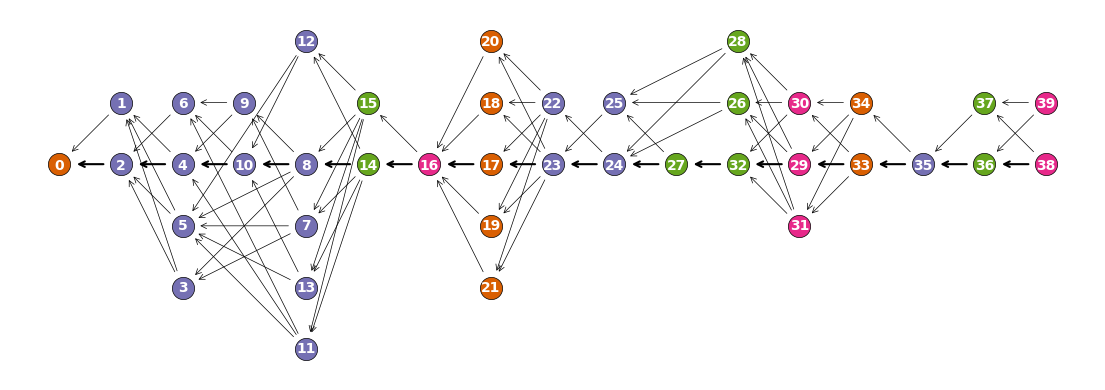

In [6]:
# Generate Fig.2 for braid_consensus.md. Your braid above is random and won't be the same.
parents = {0: set(), 1: {0}, 2: {0}, 3: {1, 2}, 4: {1, 2}, 5: {1, 2}, 6: {2}, 7: {9, 3, 5}, 8: {9, 10, 3, 5}, 9: {4, 6}, 10: {4, 6}, 11: {4, 5, 6}, 12: {10, 5}, 13: {10, 5}, 14: {7, 8, 11, 12, 13}, 15: {7, 8, 11, 12, 13}, 16: {14, 15}, 17: {16}, 18: {16}, 19: {16}, 20: {16}, 21: {16}, 22: {17, 18, 19, 20, 21}, 23: {17, 18, 19, 20, 21}, 24: {22, 23}, 25: {23}, 26: {24, 25}, 27: {24, 25}, 28: {24, 25}, 29: {32, 26, 28}, 30: {32, 26, 28}, 31: {32, 26, 28}, 32: {27}, 33: {29, 30, 31}, 34: {29, 30, 31}, 35: {33, 34}, 36: {35}, 37: {35}, 38: {36, 37}, 39: {36, 37}}
b = Braid(parents=parents)
b.plot("/tmp/thick_braid.png")

In [8]:
# This takes a few minutes to run, where the points on the right edge take the most time because N_B/N_C is large
# Change N_COHORTS to increase the accuracy of the simulation
N_COHORTS = 50
# x = MAX_HASH*exp(MIN_LOG_X) is the minimum difficulty we will consder (lower this at your peril--takes exponentially slower)
# -9.5  16.7s on 20 cores
# -9.25 52.5s  on 20 cores
# -9.0  crashes OOM
# -8.75 crashes OOM
MIN_LOG_X = -9.25

start = time.time()
# Define a function which collects times and beads as a function of target difficulty
dctimes = []
def gettimes(n, target, ncohorts=N_COHORTS):
    # re-use the same network so we don't generate differences due to different network topology, and disable difficulty adjustment
    n.reset(target=target, target_algo="fixed")
    nbeads = ncohorts/5 if target/MAX_HASH < 3e-5 else 500 # Do longer runs at low difficulty (N_B/N_C >~ 100)
    b = n.nodes[0].braid
    # Try to get roughly the same number of cohorts for each simulation point in <target>
    cache = {} # Use an ancestor cache because this loop recalculates cohorts a lot and it's slow for large cohorts
    
    while len(b.cohorts) < ncohorts:
        n.simulate(nbeads=nbeads, mine=False)
        parents = {b.beads[bead_hash]: b.beads[bead_hash].parents for bead_hash in b.beads}
        b.cohorts = list(braid.cohorts(b.parents(), ancestor_cache=cache))
    dt = np.diff([np.mean([b.t for b in c]) for c in b.cohorts])
    msg = f"At x= {target/float(MAX_HASH)} we generated {len(b.beads)} beads and {len(b.cohorts)} cohorts"
    return((float(target)/float(MAX_HASH), np.mean(dt), np.std(dt), len(b.beads), len(b.cohorts), msg))
    
# Run this function in parallel for the number of cores on your machine.
dctimes = Parallel(n_jobs=cpu_count())(delayed(gettimes)(n,d) for d in map(int, MAX_HASH*np.exp(np.arange(MIN_LOG_X, -20, -0.25))))
end = time.time()
#for data in dctimes: print(data[-1])
print(f"Run time: {end-start:6.2f}s")

Run time:  52.49s


lambda = 12012217.214633306, a=0.003229706084947334, x0=1.8132505234159507e-05, b= 39410.58538654355 = 38795.93103181031


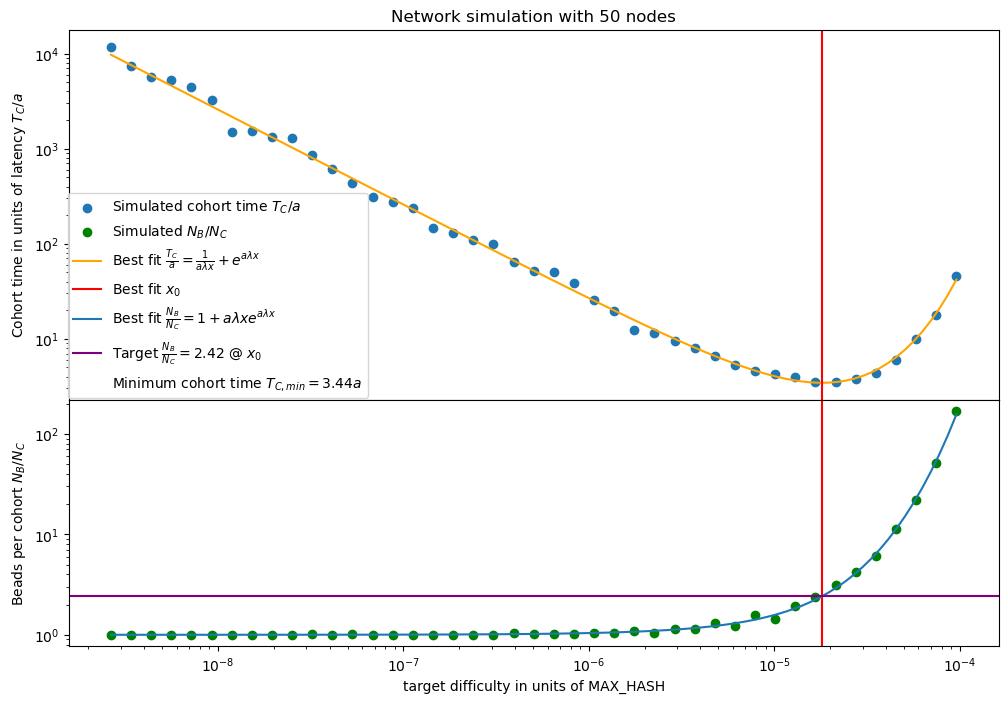

In [48]:
# Generate Figure 3 for braid_consensus.md
plt.rcParams['figure.figsize'] = [12,8]
x      = np.array([p[0] for p in dctimes])
Tcs    = np.array([p[1] for p in dctimes])
Tcserr = np.array([p[2] for p in dctimes])
Nb_Nc  = np.array([p[3]/p[4] for p in dctimes])

# Perform the curve fit for T_C in log coordinates
def f(x,lam,a): return 1/lam/x+a*np.exp(lam*a*x)
def logf(logx, lam, a): return np.log(f(np.exp(logx), lam, a))
((lam,a),dummy) = scipy.optimize.curve_fit(logf, np.log(x), np.log(Tcs), [1e7, 1e-3], bounds=([0, 0],[np.inf, np.inf]))
x0 = 2/lam/a*scipy.special.lambertw(1/2).real

# Perform the curve fit for $N_B/N_C$ where b = a*lambda
def nbnc(x, b): return 1.0+b*x*np.exp(b*x)
((b,), dummy) = scipy.optimize.curve_fit(nbnc, x, Nb_Nc)
print(f"lambda = {lam}, a={a}, x0={x0}, b= {b} = {a*lam}")

# Plot it
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, height_ratios=[1.5,1])
data1 = ax1.scatter(x, Tcs/a, label="Simulated cohort time $T_C/a$")
data2 = ax2.scatter(x, Nb_Nc, label="Simulated $N_B/N_C$", color='green')
ax2.set_ylabel("Beads per cohort $N_B/N_C$")
ax2.set_yscale('log')
x_analytic = np.logspace(log(min(x)), log(max(x)), 100, base=np.e)
data3, = ax1.loglog(x_analytic, f(x_analytic, lam, a)/a, label="Best fit $\\frac{T_C}{a} = \\frac{1}{a\lambda x} + e^{a \lambda x}$", color='orange');
data4 = ax1.axvline(np.real(x0), color='red', label=f"Best fit $x_0$")
ax2.set_xlabel('target difficulty in units of MAX_HASH')
ax2.axvline(np.real(x0), color='red', label=f"Best fit $x_0$")
data5, = ax2.plot(x_analytic, nbnc(x_analytic, a*lam), label="Best fit $\\frac{N_B}{N_C} = 1+a\lambda x e^{a\lambda x}$")
data6 = ax2.axhline(2.42, color='purple', label="Target $\\frac{N_B}{N_C} = 2.42$ @ $x_0$")
ax1.set_ylabel('Cohort time in units of latency $T_C/a$')

fig.subplots_adjust(hspace=0)
fig.legend(#loc="upper center", 
           bbox_to_anchor=(0.38,0.685), 
           handles=[data1, data2, data3, data4, data5, data6,
                    #Patch(color='white', label=f"Best fit $a$  = {a*1000:3.3} ms"),
                    Patch(color='white', label="Minimum cohort time $T_{C,min} = " + f"{1.0/a/lam/x0 + np.exp(a*lam*x0):1.3} a$")]);
                    #Patch(color='white', label=f"Best fit $\lambda$  = {lam/1_000_000:3.3} MH/s")]);
ax1.set_title(f"Network simulation with {len(n.nodes)} nodes");
fig.savefig("/tmp/T_C_x.png")

In [27]:
# Since the difficulty is changing with every bead, it's not really possible to measure b = \sqrt{2} a \lambda
# while in operation, unfortunately.
print(f"b                 = {b}")
print(f"sqrt(2)*a*lambda  = {sqrt(2)*a*lam}")
print(f"a*lambda/W(1/2)/2 = {a*lam/W(1/2).real/2}")

b                 = 60380.826943268614
sqrt(2)*a*lambda  = 64493.96759729125
a*lambda/W(1/2)/2 = 64827.6243862229
At x= 1.300729765406762e-05 we generated 151 beads and 68 cohorts
At x= 2.7536449349747158e-05 we generated 251 beads and 54 cohorts
At x= 1.670170079024566e-05 we generated 151 beads and 67 cohorts
At x= 5.602796437537268e-09 we generated 51 beads and 51 cohorts
At x= 6.475952175842209e-07 we generated 101 beads and 98 cohorts
At x= 7.485182988770058e-05 we generated 4501 beads and 50 cohorts
At x= 4.5399929762484854e-05 we generated 1001 beads and 74 cohorts
At x= 2.1445408316589164e-05 we generated 201 beads and 55 cohorts
At x= 1.0677040100347827e-06 we generated 101 beads and 96 cohorts
At x= 6.82560337633487e-08 we generated 51 beads and 51 cohorts
At x= 9.237449661970594e-09 we generated 51 beads and 51 cohorts
At x= 7.889324827200223e-06 we generated 101 beads and 74 cohorts
At x= 3.059023205018258e-07 we generated 51 beads and 50 cohorts
At x= 1.522997974471263e-08

In [22]:
len(n.nodes[0].braid.beads)

41

In [13]:
# Difficulty adjustment tests
n.reset(target_algo="simple")
n.simulate(1000)

In [29]:
TARGET_NB = 247
TARGET_NC = 102
N_BEADS   = 5000 # Number of beads per run
N_RUNS    = 5    # Number of runs to average
# Get cohort times for one run (we will do this in parallel for speed)
def get_cohort_times(n):
    # Generator for a moving average
    def ma_iterate(L, chunk_size=TARGET_NC):
        for i in range(0, len(L), chunk_size):
            yield L[i:i+chunk_size]

    n.reset(target_algo="simple")
    n.simulate(N_BEADS)
    for cohorts in ma_iterate(n.nodes[0].braid.cohorts):
        beads = set.union(*cohorts)
        ma_nbnc_times[np.median([b.t for b in beads])] = len(beads)/TARGET_NC
    return ma_nbnc_times
ma_nbnc_times = reduce(lambda x,y: {**x, **y}, Parallel(n_jobs=cpu_count())(delayed(get_cohort_times)(n) for _ in range(N_RUNS)))

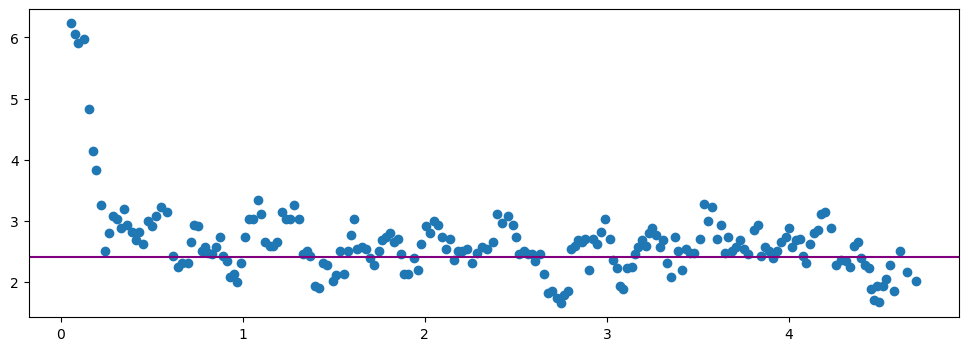

In [30]:
x2 = np.convolve(x, np.ones(N_RUNS)/N_RUNS, mode='valid')
y2 = np.convolve(y, np.ones(N_RUNS)/N_RUNS, mode='valid')
fig,ax = plt.subplots()
ax.scatter(x2, y2)
ax.axhline(2.42, color='purple')

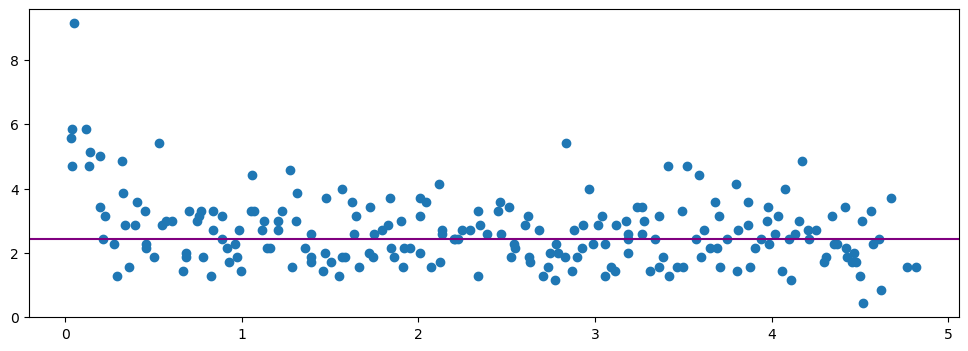

In [13]:
#mactimes = np.convolve(nb_nc, np.ones(7)/7, mode='valid')
#plt.scatter(ctimes, nb_nc)
fix,ax = plt.subplots()
x = np.array(list(sorted(ma_nbnc_times.keys())))
y = np.array(list(ma_nbnc_times[xi] for xi in x))
ax.scatter(x, y)
ax.axhline(2.42, color='purple')